In [1]:
# GPU selection
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 35 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.3   # data for validation (not used in training)

In [3]:
import numpy as np
import re, sys, csv, pickle
from tqdm import tqdm_notebook

import tensorflow as tf
import tensorflow_hub as hub

from keras import regularizers, initializers, optimizers, callbacks
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [18]:
texts = []   # empty list for model input: the movie reviews
labels = []  # empty lists model output: sentiment labels

data = open("../datasets/quote.tok.gt9.5000", "r", errors='ignore') 
for line in tqdm_notebook(data, total=5000): 
    texts.append(str(line).rstrip('\n').strip())
    labels.append(int(1)) # subjective

In [19]:
data = open("../datasets/plot.tok.gt9.5000", "r") 
for line in tqdm_notebook(data, total=5000): 
    texts.append(str(line).rstrip('\n').strip())
    labels.append(int(0)) # objective

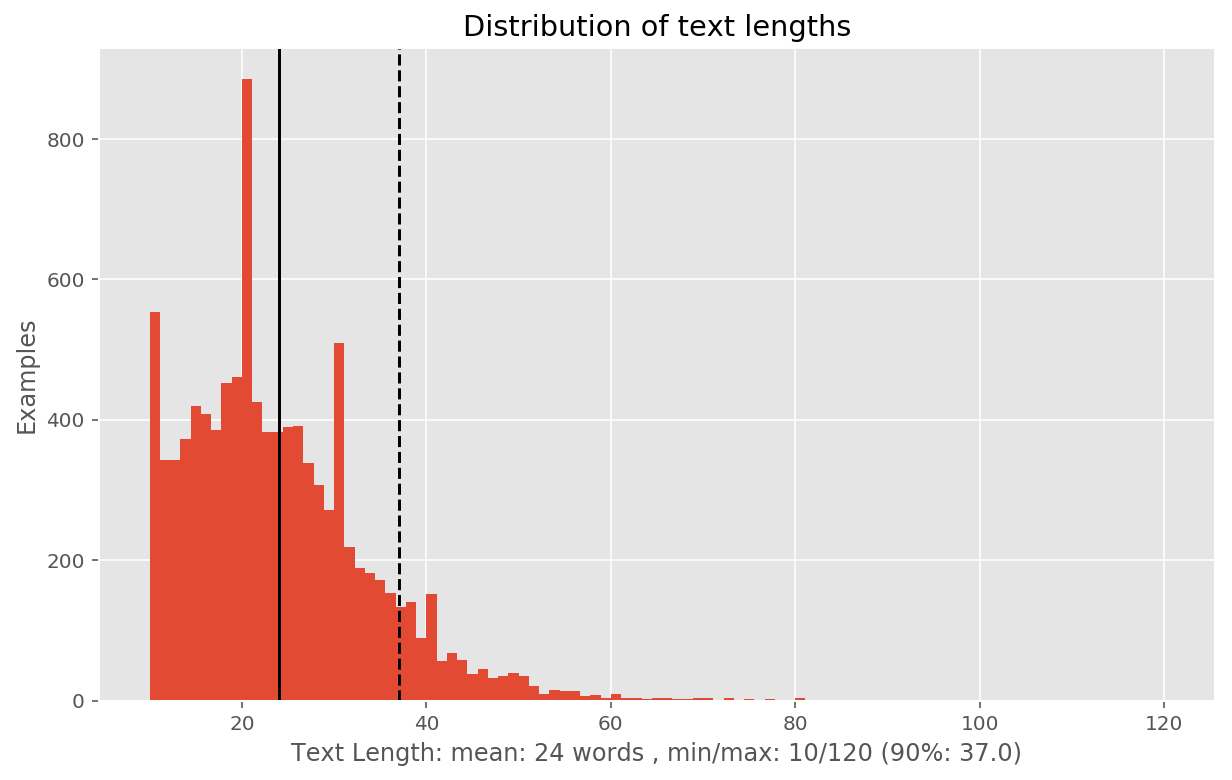

In [20]:
import  matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')
lengths = np.array([len(row.split(" ")) for row in texts])
summary = "mean: "+str(int(np.mean(lengths)))+" words , min/max: "+str(np.min(lengths))+"/"+str(np.max(lengths))+" (90%: "+ str(round(np.percentile(lengths, 90), 2)) + ")"
plt.figure(1, figsize=(10,6))
plt.hist(lengths, bins='auto')
plt.title("Distribution of text lengths")
plt.xlabel("Text Length: " + summary); plt.ylabel("Examples")
plt.axvline(np.mean(lengths), ls="-", color="k")
plt.axvline(np.percentile(lengths, 90), ls="--", color="k")
plt.show()

In [21]:
print("Sample subjective:", texts[0], labels[0])
print("Sample objective:", texts[9000], labels[9000])

Sample subjective: smart and alert , thirteen conversations about one thing is a small gem . 1
Sample objective: atlantic city serenade is about the price we pay for the choices we make in the quest for power over our own inner demons . 0


In [22]:
all_text = [' '.join(t.split()[0:MAX_SEQUENCE_LENGTH]) for t in texts]
all_text = np.array(all_text, dtype=object)[:, np.newaxis]

labels = to_categorical(np.asarray(labels)) # convert the category label to one-hot encoding
print('[i] Shape of data tensor:', all_text.shape)
print('[i] Shape of label tensor:', labels.shape)

indices = np.arange(all_text.shape[0])
np.random.shuffle(indices)
all_text = all_text[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * all_text.shape[0])
x_train = all_text[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = all_text[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('[i] Number of entries in each category:')
print("[+] Training:",y_train.sum(axis=0))
print("[+] Validation:",y_val.sum(axis=0))

[i] Shape of data tensor: (10000, 1)
[i] Shape of label tensor: (10000, 2)
[i] Number of entries in each category:
[+] Training: [3529. 3471.]
[+] Validation: [1471. 1529.]


In [23]:
print("Sentence input" , all_text[0])
print(" ")
print("One-hot label", labels[0])

Sentence input ["piccoli's performance is amazing , yes , but the symbols of loss and denial and life-at-arm's-length in the film seem irritatingly transparent ."]
 
One-hot label [0. 1.]


In [10]:
# Initialize session
sess = tf.Session()
K.set_session(sess)

In [11]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/elmo/2'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/elmo/2'.


In [12]:
sequence_input = Input(shape=(1,), dtype=tf.string)
embedded_sequences = Lambda(ElmoEmbedding, output_shape=(1024,))(sequence_input)
embedded_sequences = Reshape((1024, 1,))(embedded_sequences)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
l_drop = Dropout(0.4)(embedded_sequences)
l_flat = Flatten()(l_drop)
l_dense = Dense(32, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

In [14]:
adam = optimizers.Adam(lr=0.0011, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1024, 1)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024, 1)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                32800     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total para

In [24]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                               epochs=5, batch_size=100)

Training Progress:
Train on 7000 samples, validate on 3000 samples
Epoch 1/5
7000/7000 [==============================] - 26s 4ms/step - loss: 0.1895 - acc: 0.9283 - val_loss: 0.1525 - val_acc: 0.9463
Epoch 2/5
7000/7000 [==============================] - 26s 4ms/step - loss: 0.1858 - acc: 0.9279 - val_loss: 0.1519 - val_acc: 0.9453
Epoch 3/5
7000/7000 [==============================] - 26s 4ms/step - loss: 0.1817 - acc: 0.9299 - val_loss: 0.1507 - val_acc: 0.9467
Epoch 4/5
7000/7000 [==============================] - 26s 4ms/step - loss: 0.1848 - acc: 0.9280 - val_loss: 0.1513 - val_acc: 0.9447
Epoch 5/5
7000/7000 [==============================] - 26s 4ms/step - loss: 0.1822 - acc: 0.9286 - val_loss: 0.1498 - val_acc: 0.9473


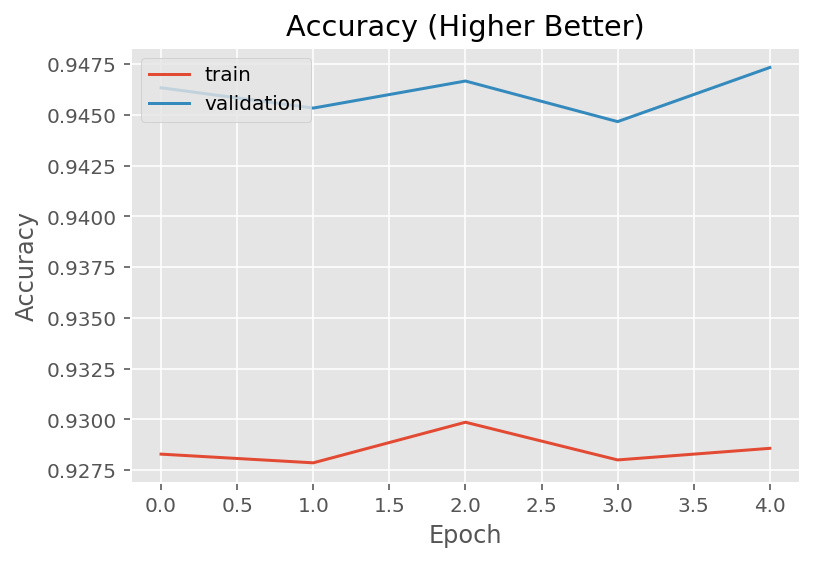

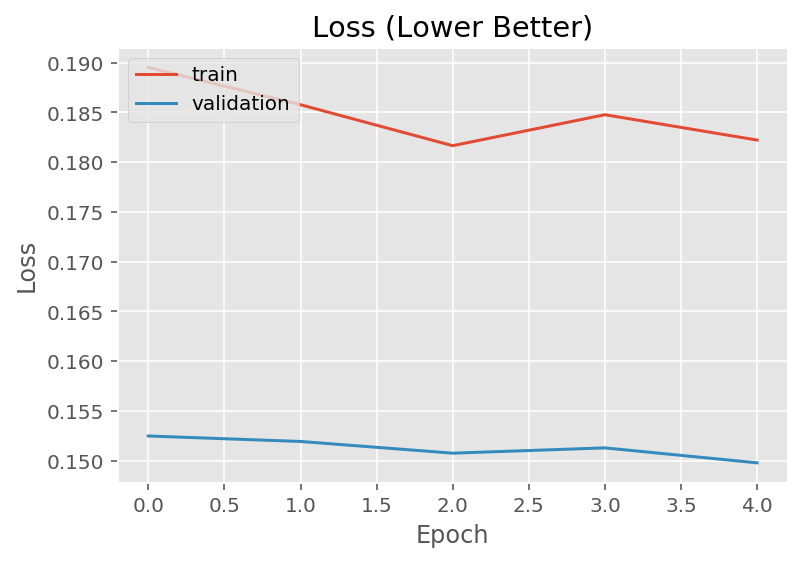

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('Accuracy (Higher Better)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Loss (Lower Better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

classes = ["subjective", "objective"]

In [27]:
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
print(classification_report(Y_test, y_pred_class, target_names=classes))

             precision    recall  f1-score   support

 subjective       0.95      0.94      0.95      1471
  objective       0.94      0.96      0.95      1529

avg / total       0.95      0.95      0.95      3000



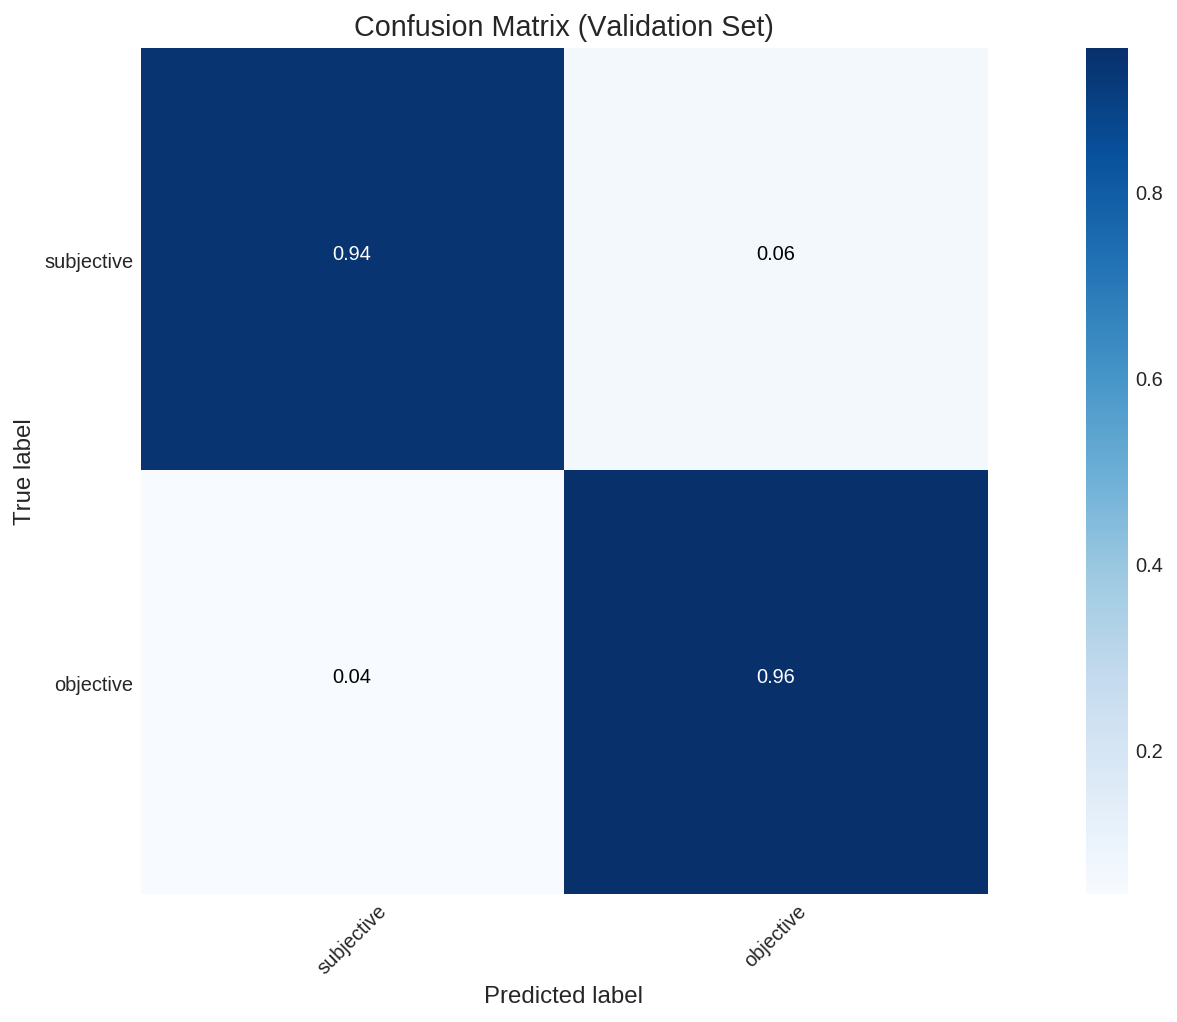

In [28]:
plt.style.use('seaborn-dark')
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(14,7))
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
plot_confusion_matrix(cnf_matrix, labels=classes)

In [30]:
model.save_weights("subjectivity.h5")

In [31]:
yaml_string = model.to_yaml()